# Satellite data for climate change monitoring

Production date: 10-28-2024

Produced by: Camila Trigoso (VUB)

## 🌍 Use case: Utilize satellite-derived lake surface water temperature data for climate change  monitoring

## ❓ Quality assessment question(s)
* **Can satellite data be used to detect the observed increase in summer water temperatures in Lake Superior due to global warming?**

Cases of an increasing trend in lake surface water temperature (LSWT) have been observed in numerous lakes across various regions, including the United States, Europe, and other parts of the world. [1][2]. For example, in Lake Superior, Austin and Colman found that summer LSWT (July, August, and September) increased at a rate of (11±6)×10^-2 °C per year from 1979 to 2006. They attribute this trend to the earlier retreat of winter ice, which causes the positive overturning period to begin sooner, allowing the lake more time to warm. Their analysis was based on measurements from in-situ buoys [3].

On a different study, the United States Environmental Protection Agency (EPA) used satellite-derived LSWT data, provided by NOAA, as a climate change indicator for the Great Lakes. A slight increase in LSWT has been observed over the period of 1995 to 2023 in the Great Lakes, particularly during the spring and summer seasons [4].

The objective of this study is to evaluate whether the [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset is suitable for climate change monitoring, using Lake Superior as a case study. This study also aims to compare the results derived from this dataset with findings in the existing literature.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) is suitable for climate change monitoring using data of quality level 4 and 5. It has data from 1995 to 2023, almost 30 years of data which are nessary to observe climate trends.  
* Complementing the data with that of previous year from in-situ measurments is necessary to have a fuller picture of the behavior of the climate trend of the LSWT.
* The dataset has information for more locations the insitu buoys could gather. Both insitu and satelite derived data have pros anc cons that have to be weightes for their analisys and can be complementary.
* The dataset had very similar values for the daily mean of LSWT to the ones used for analysis by the NOAA. 
```

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download satellite water temperature data for the summer months (July, August, September) between 1995 to 2023.

**[](section-2)**
 * Filter the data by quality level and lakeid.
 * Calculate the spatial weighted mean of LSWT.

**[](section-3)**
 * Calculate the summer yearly mean of LSWT, perform linear regression to obtain the slope and plot.
 
**[](section-4)** 
 * Plot summer daily LSWT for two time periods for comparison: 2014–2023 versus 1995–2004.


## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.cbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from scipy.stats import linregress
from matplotlib.lines import Line2D
plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [2]:
# Time
year_start = 1995
year_stop = 2023

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request

In [3]:
collection_id = "satellite-lake-water-temperature"
requests = []
for year in range(year_start, year_stop + 1):
    requests.append(
        {
            "variable": "all",
            "year": [str(year)],
            "month": ["07", "08", "09"],
            "day": [f"{day:02d}" for day in range(1, 32)],
            "version": ["4_5" if year < 2021 else "4_5_2"],
        }
    )

#### Download data

In [4]:
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


(section-2)=
### 2. Data preprocessing 

#### Plot lakeid

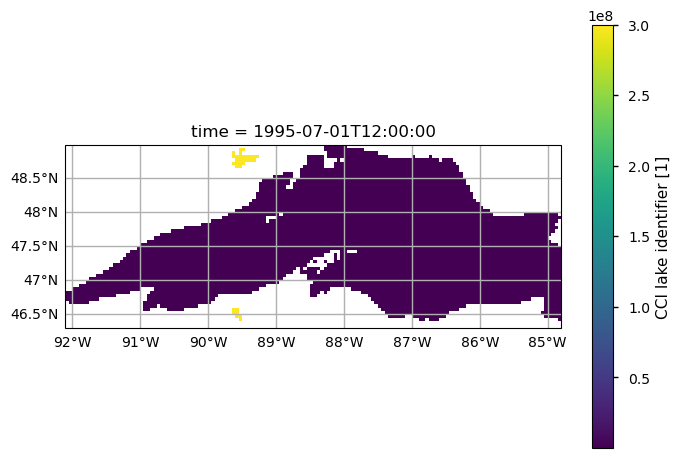

In [5]:
_ = plot.projected_map(
    ds["lakeid_CCI"].isel(time=0),
    projection=ccrs.PlateCarree(),
    show_stats=False,
)

In [10]:
print(ds["lakeid_CCI"].values)

[        2 300000709 300008645]


#### Data filtering

It can be observed that the lakeid of Lake Superior is 2.
Regarding the quality level. We will only use these levels:
- 4: good quality
- 5: best quality

In [11]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid_CCI"].values), dims=("lakeid_CCI"))
    .dropna("lakeid_CCI")
    .astype(int)
)
min_quality_level = xr.DataArray([0, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid_CCI").where(ds["lakeid_CCI"] == lakeid)
ds = ds.where(ds["lswt_quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid_CCI=lakeid, min_quality_level=min_quality_level)

filtered_ds = ds.sel(lakeid_CCI=2, min_quality_level=4)

#### Spatial weighted mean

In [12]:
# Spatial weighted mean
da = diagnostics.spatial_weighted_mean(filtered_ds[varname])

(section-3)=
### 3. Summer yearly mean analisys
#### Yearly mean and standard error of the mean (SEM)

In [23]:
#Convert to °C
daC = da - 273.15 #We convert to °C for comparison with Austin & Colman (2007)
#Calculate the mean
yearly_mean = daC.groupby('time.year').mean(dim='time')
#Calculate the standard deviation
yearly_std_dev = daC.groupby('time.year').std(dim='time')
#Calculate the SEM
yearly_counts = daC.groupby('time.year').count(dim='time')
yearly_sem  = yearly_std_dev / np.sqrt(yearly_counts)
#Calculate the 95% confidence interval
ci_lower = yearly_mean - 1.96 * yearly_sem
ci_upper = yearly_mean + 1.96 * yearly_sem

#### Perform linear regression for the full set (1995-2023)

In [24]:
# Define the years for the full dataset and subset
years_full = yearly_mean['year'].values

# Perform linear regression on the full dataset
slope_full, intercept_full, r_value, p_value, std_err = linregress(years_full, yearly_mean.values)
trend_full = slope_full * years_full + intercept_full

# Print the linear regression equation in a readable format
print(f"The equation of the trend line is: \ny = {slope_full:.4f} °C/year * x + {intercept_full:.4f} °C")
# Printing the results
print("\nSlope of the trend line:", slope_full)
print("Intercept of the trend line:", intercept_full)
print("Correlation coefficient (R value):", r_value)
print("P-value of the regression:", p_value)
print("Standard error of the slope:", std_err)


The equation of the trend line is: 
y = -0.0133 °C/year * x + 40.7965 °C

Slope of the trend line: -0.013301255080500257
Intercept of the trend line: 40.79652603741349
Correlation coefficient (R value): -0.08872107726551373
P-value of the regression: 0.6471925297501394
Standard error of the slope: 0.028738752463611027


#### Perform linear regression for a subset from 1995 to 2006

In [25]:
#Create the subset
subset_1995_2006 = daC.sel(time=slice(f"1995-07-01", f"2006-09-30"))

subset_mean = subset_1995_2006.groupby('time.year').mean(dim='time')

# Define the years for the full dataset and subset
subset_years = subset_mean['year'].values

# Perform linear regression on the full dataset
slope_subset, intercept_subset, _, _, _ = linregress(subset_years, subset_mean.values)
trend_subset = slope_subset * subset_years + intercept_subset

# Print the equation of the trend line for clarity
print(f"The equation of the trend line for the subset (1995-2006) is: \ny = {slope_subset:.4f} °C/year * x + {intercept_subset:.4f} °C")

# Print the results of the linear regression for the subset (1995-2006)
print("\nSubset Linear Regression Results (1995-2006):")
print("Slope of the trend line:", slope_subset)
print("Intercept of the trend line:", intercept_subset)
print("Correlation coefficient (R value):", r_value)
print("P-value of the regression:", p_value)
print("Standard error of the slope:", std_err)

The equation of the trend line for the subset (1995-2006) is: 
y = 0.0386 °C/year * x + -62.9138 °C

Subset Linear Regression Results (1995-2006):
Slope of the trend line: 0.03858891066971359
Intercept of the trend line: -62.913759128197086
Correlation coefficient (R value): -0.08872107726551373
P-value of the regression: 0.6471925297501394
Standard error of the slope: 0.028738752463611027


#### Plot results

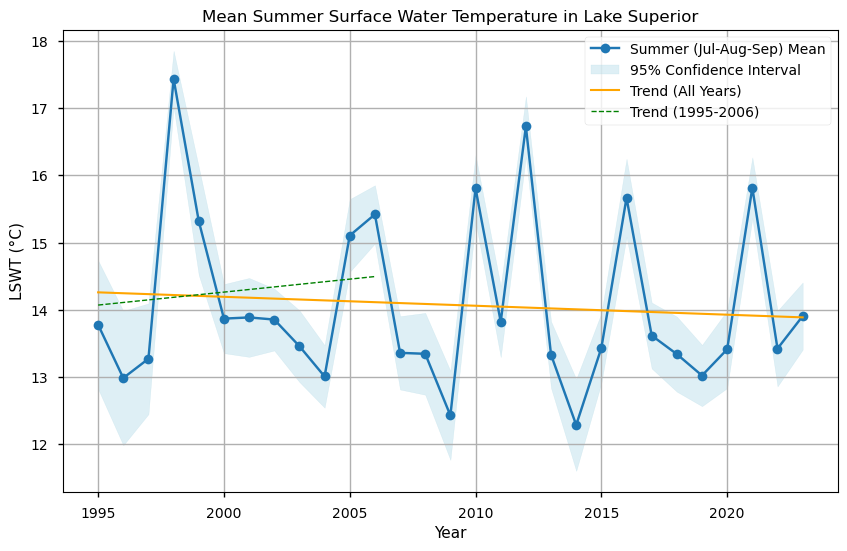

In [27]:
# Plot both the original data and the trend lines
plt.figure(figsize=(10, 6))

#Plot yearly mean with 95% confidence interval
plt.plot(years_full, yearly_mean, label="Summer (Jul-Aug-Sep) Mean", marker="o")
plt.fill_between(years_full, ci_lower, ci_upper, color="lightblue", alpha=0.4, label="95% Confidence Interval")

# Plot the trend lines
plt.plot(years_full, trend_full, label="Trend (All Years)", color="orange",  linestyle="-", linewidth=1.5)
plt.plot(subset_years, trend_subset, label="Trend (1995-2006)", color="green", linestyle="--", linewidth=1)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("LSWT (°C)")  # Adjust units if necessary
plt.title("Mean Summer Surface Water Temperature in Lake Superior")
plt.legend()
plt.grid(True)
plt.show()

#### Comparison to literature


Austin and Colman found that summer LSWT (July, August, and September) increased at a rate of (11±6)×10^-2 °C per year from 1979 to 2006 [3]. Figure 1 shows the data from this paper obtained from 3 buoys, the average value for 1995 was 11.17 °C and 14.83 °C for 2005. In contrast in our analisys the mean LSWT was 13.8 °C for 1995 and 15.1 °C for 2005.
In our analysis, the earliest year we had information for was 1995, the slope of the trend for the period 1995 to 2006 was (39±3)×10^-2 °C per year. For all the years we have available data, 1995-2023, the slope was negative, (-13±3)×10^-2 °C per year. This suggests that the warming of Lake Superior ocurred mostly on beetwen 1980 and 1990 (observe Figure 2) and later acording to our data there was a slight cooling trend for summer in more recent years specifically on this lake.

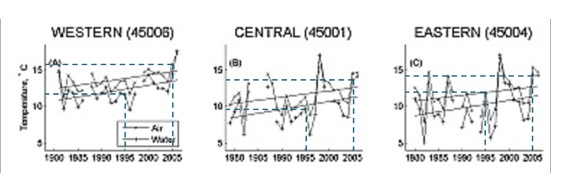
##### Figure 1
Summer (July–September) mean air temperatures (cross) and water temperatures (plus). Obtained from Austin&Colman (2007) [4]. and modified for explanation.

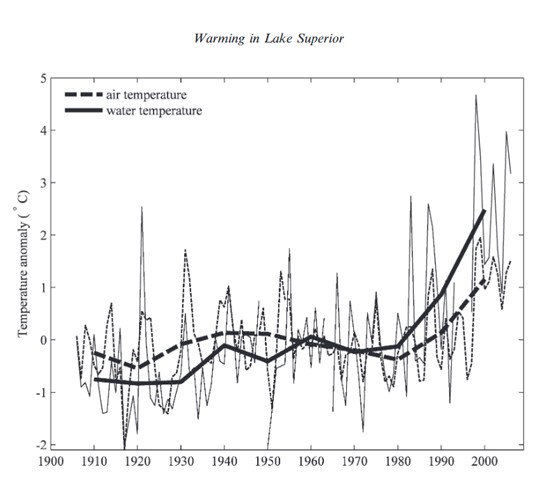
##### Figure 2
Summer mean water-temperature anomaly from Sault Ste. Marie (SSM) time series open-lake proxy (solid curve) and air temperature anomaly from regional Goddard Institute for Space Science (GISS) stations (dashed curve). Light lines are annual data, heavy lines are decadal averages. Warming in Lake Superior 2729. Obtained from Austin&Colman (2008) [5].


(section-4)=
### 4. Daily mean for two periods

#### Create the subsets for periods: 1995-2004 and 2014-2023

In [28]:
# Select data for the two time intervals.
interval1 = da.sel(time=slice("1995-07-01", "2004-09-30"))
interval2 = da.sel(time=slice("2014-07-01", "2023-09-30"))

# Group by the day of the year.
interval1_grouped = interval1.groupby("time.dayofyear")
interval2_grouped = interval2.groupby("time.dayofyear")

# Calculate the average for matching days.
interval1_mean = interval1_grouped.mean(dim="time")
interval2_mean = interval2_grouped.mean(dim="time")

# Convert interval1_mean and interval2_mean from Kelvin to Fahrenheit
#We convert to °F for comparison with EPA (2024)
interval1_mean_F = (interval1_mean - 273.15) * (9/5) + 32
interval2_mean_F = (interval2_mean - 273.15) * (9/5) + 32

#### Create the subsets for periods: 1995-2004 and 2014-2023

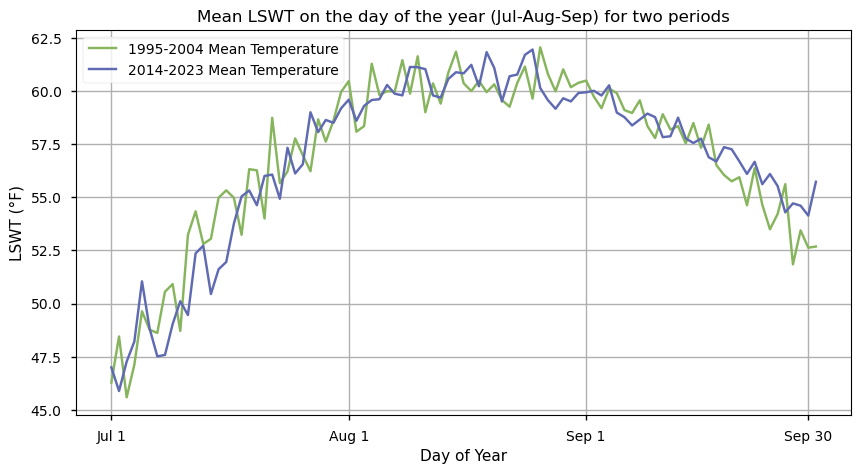

In [30]:
# Create the plot
plt.figure(figsize=(10, 5))

# Plot interval 1 mean (1995-2004) with label and color
interval1_mean_F.plot(label='1995-2004 Mean Temperature', color='#87B55D')

# Plot interval 2 mean (2014-2023) with label and color
interval2_mean_F.plot(label='2014-2023 Mean Temperature', color="#5F6AB2")

# Set x-ticks to represent the days from July 1 to September 30
plt.xticks([182, 213, 244, 273], ['Jul 1', 'Aug 1', 'Sep 1', 'Sep 30'])
# Add title and labels
plt.title("Mean LSWT on the day of the year (Jul-Aug-Sep) for two periods")
plt.xlabel("Day of Year")
plt.ylabel("LSWT (°F)")

plt.grid(True)
# Show legend
plt.legend()

# Display the plot
plt.show()

#### Comparison to literature

Figure 2 shows an analysis similar to the one obtained by the code, but for all days of the year. It shows that the LSWT for both periods of time is very similar. The only differences that stand out for the period of July, August and September are on mid August and slightly lower temperatures at the end of September for the period of 1995-2004. Comparing to our results, The values of LSWT in the period analyzed are very similar. However, the dip observed on around the 20th of August is not notizable in our analysis. 

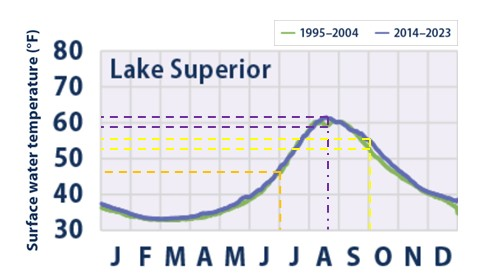
##### Figure 3
Average daily temperatures change between two time periods for comparison: 2014–2023 versus 1995–2004. Obtained from EPA (2024) [4] and modified for explanation.

## ℹ️ If you want to know more

### Key resources

Dataset documentation:
[LSWT v4.5: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

### References

List the references used in the Notebook here.


[[1]](https://doi.org/10.1038/s41558-024-02122-y) Wang, X., Shi, K., Qin, B. et al. (2024). Disproportionate impact of atmospheric heat events on lake surface water temperature increases. Nat. Clim. Chang.
[[2]](https://climate.copernicus.eu/lake-surface-temperatures) Copernicus (2018). Lake surface temperatures. Climate Chenge Service.
[[3]](https://doi.org/10.1029/2006GL029021) Jay A. Austin, Steven M. Colman (2007). Lake Superior summer water temperatures are increasing more rapidly than regional air temperatures: A positive ice-albedo feedback. Geophysical Research LettersVolume 34, Issue 6. 
[[4]](https://www.epa.gov/climate-indicators/great-lakes) EPA (2024).  Climate Change Indicators: Great Lakes Water Levels and Temperatures.
[[5]](https://www.researchgate.net/publication/262138032_A_Century_of_Temperature_Variability_in_Lake_Superior) Jay A. Austin, Steven M. Colman (2007). A Century of Temperature Variability in Lake Superior. Limnology and Oceanography 53(6):2724-2730.